In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np
import scipy.stats as st
import seaborn as sns

from tqdm import tqdm
from datetime import timedelta, datetime
from sklearn.decomposition import NMF

In [2]:
tqdm.pandas()

In [3]:
billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["year"] > 1958) & (billboard_hot_100["year"] < 2023)]
billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
1611,1611,1959-01-12,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,7,Not Listed,Not Listed,Liberty,1959
1615,1615,1959-01-05,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,6,Not Listed,Not Listed,Liberty,1959
1628,1628,1959-01-12,The Platters,Smoke Gets In Your Eyes,2,2.0,2,9,"O.Harbach, J.Kern",Not Listed,Mercury,1959
1629,1629,1959-01-12,Connie Francis,My Happiness,3,6.0,3,6,"B.Bergantine, B.Peterson",Not Listed,MGM,1959
1630,1630,1959-01-12,Billy Grammer,Gotta Travel On,4,9.0,4,8,"P.Clayton, L.Ehrlich, R.Gilbert, L.Hays, F.Hel...",Not Listed,Monument,1959


In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["top_position"] = billboard_hot_100.groupby("artist_song")["position"].transform("min")

In [6]:
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
def moving_average(x, w):
    return np.convolve(x, np.ones(w) / w, 'valid')

## Rank turnover

In [7]:
# number of songs ever seen until time t
def number_of_songs_seen(df, t):
    return len(df[df["first_day_of_the_week"] <= t]["artist_song"].unique())/100

3339it [04:20, 12.80it/s]


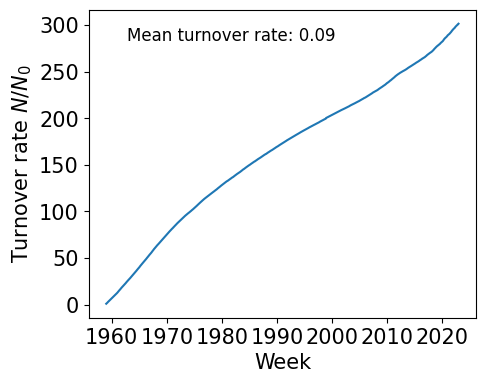

In [23]:
number_of_songs_ever_seen = []

for l, first_day_of_the_week in tqdm(enumerate(billboard_hot_100["first_day_of_the_week"].sort_values().unique())):
    number_of_songs_ever_seen.append(number_of_songs_seen(billboard_hot_100, first_day_of_the_week))

plt.figure(figsize=(5, 4))
plt.plot(billboard_hot_100["first_day_of_the_week"].sort_values().unique(), number_of_songs_ever_seen)
plt.xlabel("Week")
plt.ylabel(r"Turnover rate $N/N_0$")

T_size = len(billboard_hot_100["first_day_of_the_week"].sort_values().unique())
mean_turnover = (number_of_songs_ever_seen[len(number_of_songs_ever_seen) - 1] - number_of_songs_ever_seen[0]) / (T_size - 1)
#print("Mean turnover rate: " + str(mean_turnover))
plt.text(0.1, 0.9, "Mean turnover rate: " + str(round(mean_turnover, 2)), transform=plt.gca().transAxes, fontsize=12)

plt.savefig("figures/number_of_songs_ever_seen.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Rank flux

In [20]:
# probabilities that song enter or leaves the chart at time t
def song_enter_leave_probabilities(df, t):
    songs_previous_week = df[df["first_day_of_the_week"] == (pd.to_datetime(t) - timedelta(weeks=1))]["artist_song"].unique()
    songs_now = df[df["first_day_of_the_week"] == t]["artist_song"].unique()
    songs_entered = list(set(songs_now) - set(songs_previous_week))
    return len(songs_entered)/100

100%|██████████| 3339/3339 [00:26<00:00, 127.76it/s]


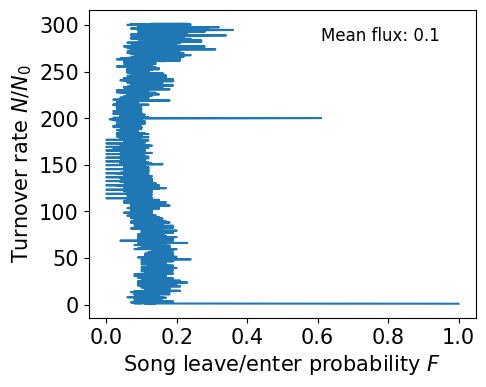

In [22]:
enter_leave_porbabilities = []
for first_day_of_the_week in tqdm(billboard_hot_100["first_day_of_the_week"].sort_values().unique()):
    enter_leave_porbabilities.append(song_enter_leave_probabilities(billboard_hot_100, first_day_of_the_week))

plt.figure(figsize=(5, 4))
plt.plot(enter_leave_porbabilities, number_of_songs_ever_seen)
plt.xlabel(r"Song leave/enter probability $F$")
plt.ylabel(r"Turnover rate $N/N_0$")
# plt.yscale("log")
# plt.xscale("log")

mean_flux = np.mean(enter_leave_porbabilities)
#print("Mean flux: " + str(mean_flux))
plt.text(0.6, 0.9, "Mean flux: " + str(round(mean_flux, 2)), transform=plt.gca().transAxes, fontsize=12)

plt.savefig("figures/enter_leave_probabilities.pdf", format="pdf", bbox_inches="tight")
plt.show()

100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


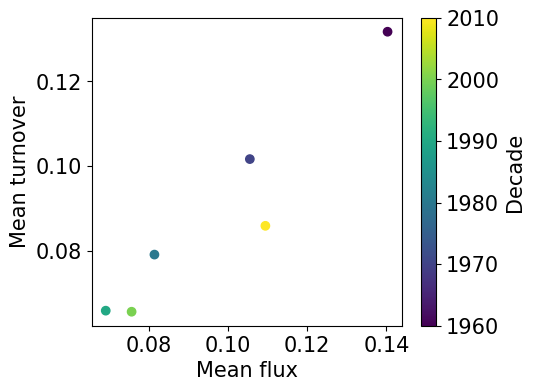

In [25]:
fluxes = []
turnovers = []

plt.figure(figsize=(5, 4))

for year in tqdm(range(1960, 2011, 10)):
    decade = billboard_hot_100[(billboard_hot_100["year"] >= year) & (billboard_hot_100["year"] < year + 10)]
    enter_leave_porbabilities = []
    number_of_songs_ever_seen = []
    for first_day_of_the_week in decade["first_day_of_the_week"].sort_values().unique():
        enter_leave_porbabilities.append(song_enter_leave_probabilities(decade, first_day_of_the_week))
        number_of_songs_ever_seen.append(number_of_songs_seen(decade, first_day_of_the_week))
    T_size = len(decade["first_day_of_the_week"].sort_values().unique())
    mean_flux = np.mean(enter_leave_porbabilities)
    mean_turnover = (number_of_songs_ever_seen[len(number_of_songs_ever_seen) - 1] - number_of_songs_ever_seen[0]) / (T_size - 1)
    fluxes.append(mean_flux)
    turnovers.append(mean_turnover)

plt.scatter(fluxes, turnovers, c=range(1960, 2011, 10))
plt.xlabel("Mean flux")
plt.ylabel("Mean turnover")
plt.colorbar(label="Decade")
plt.savefig("figures/flux_turnover_over_time.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [26]:
print("p0: " + str(100 / billboard_hot_100["artist_song"].nunique()))

p0: 0.0033170796430822304


## Rank change - Probability that element at position R changes between t-1 and time t 

In [27]:
billboard_hot_100["position_changed"] = billboard_hot_100["position"] != billboard_hot_100["last_week_position"]

In [28]:
# calculate probability that the songs at position R changed positionb between t-1 and t
def position_change_probability(df, R):
    df_position_r = df[df["position"] == R]
    
    number_of_songs_that_changed_position = len(df_position_r[df_position_r["position_changed"] == True])
    return number_of_songs_that_changed_position/df_position_r.shape[0]

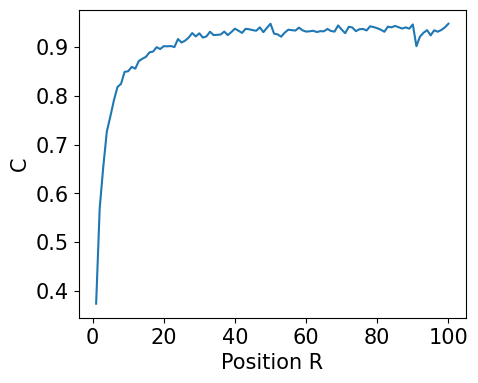

In [29]:
position_change_probabilities = []
for R in range(1, 101):
    position_change_probabilities.append(position_change_probability(billboard_hot_100, R))

plt.figure(figsize=(5, 4))
plt.plot(range(1, 101), position_change_probabilities)
plt.xlabel("Position R")
plt.ylabel("C")
plt.savefig("figures/position_change_probabilities.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Displacement probability

In [30]:
all_t = billboard_hot_100["first_day_of_the_week"].sort_values().unique()
data = {}
for t in tqdm(all_t[1:]):
    data[t] = {}
    for rank in range(1, 101):
        data[t][rank] = billboard_hot_100[(billboard_hot_100["position"] == rank) &\
            (billboard_hot_100["first_day_of_the_week"] == t)]["artist_song"].array

100%|██████████| 3338/3338 [22:54<00:00,  2.43it/s]


### t=1

In [31]:
def probability(df, initial_rank, new_pos, t):
    init_rank_df = data[(pd.to_datetime(t) + timedelta(weeks=-1)).to_datetime64()][initial_rank]
    time_after_df = data[t][new_pos]
    new_pos_after_t = set(init_rank_df).intersection(set(time_after_df))
    return len(new_pos_after_t) / len(init_rank_df)

4it [03:32, 53.04s/it]


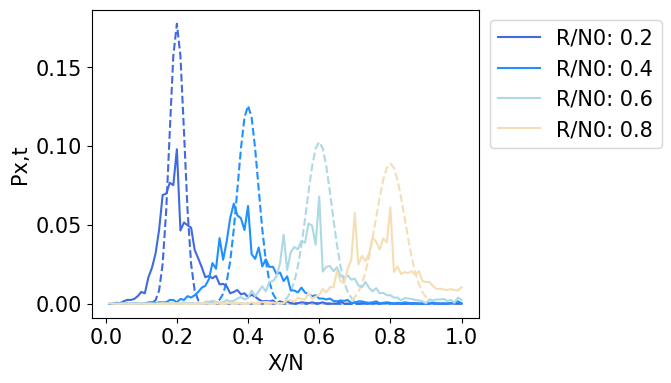

In [33]:
import math
# https://www.desmos.com/calculator/gbypgswp6c
# v = 0.0021 - a randomly chosen element gets replaced by a new one with probability ν
# tau = 0.1024 - element moves to a randomly selected rank with probability τ
tau = 0.1024
v = 0.0021
N = billboard_hot_100["artist_song"].nunique()
N0 = 100
p0 = N0 / N
initial_ranks = [20, 40, 60, 80]
pxts = []
dr = 1/N

plt.figure(figsize=(5, 4))

colors = ["royalblue", "dodgerblue", "lightblue", "wheat", "sandybrown", "chocolate"]
#model
for i, initial_rank in enumerate(initial_ranks):
    #https://github.com/iniguezg/Farranks/tree/9b661fb269b52a381bc47662d0f573bbdafe011c
    r = (initial_rank) * dr
    ptau, pnu = tau, v

    dr = 1 / float( N ) #rank increment
    p0 = N0 / float( N ) #ranking fraction

    x_vals = np.linspace( dr, p0, num=N0 ) #values of displaced rank

    levi_sea = dr * ( 1 - np.exp( -ptau ) )
    peak_sdev = np.sqrt( 2 * ptau * dr * r * (1 - r) )
    disp_theo = np.exp( -pnu ) * ( levi_sea + np.exp( -ptau ) * st.norm.pdf( x_vals, loc=r, scale=peak_sdev ) * dr )

    pxts.append(disp_theo)

xplot = np.arange( 1, 101 ) / 100
for i, initial_rank in enumerate(initial_ranks):
    plt.plot(xplot, pxts[i], c=colors[i], linestyle="dashed")

#data
pxts = []
for i, initial_rank in tqdm(enumerate(initial_ranks)):
    pxts.append([])
    for j, pos in enumerate(range(1, 101)):
        pxts[i].append([])
        for t in all_t[2:]:
            try:
                Pxt = probability(data, initial_rank, pos, t)
                pxts[i][j].append(Pxt)
            except Exception as e:
                continue
        pxts[i][j] = np.mean(pxts[i][j])

for i, initial_rank in enumerate(initial_ranks):
    plt.plot(xplot, pxts[i], label=f"R/N0: {initial_rank/100}", c=colors[i])

plt.ylabel("Px,t")
plt.xlabel("X/N")
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("figures/pxt.pdf", format="pdf", bbox_inches="tight")
plt.show()

### t=4

In [34]:
def probability_4(df, initial_rank, new_pos, t):
    init_rank_df = data[(pd.to_datetime(t) + timedelta(weeks=-4)).to_datetime64()][initial_rank]
    time_after_df = data[t][new_pos]
    new_pos_after_t = set(init_rank_df).intersection(set(time_after_df))
    return len(new_pos_after_t) / len(init_rank_df)

4it [01:54, 28.68s/it]


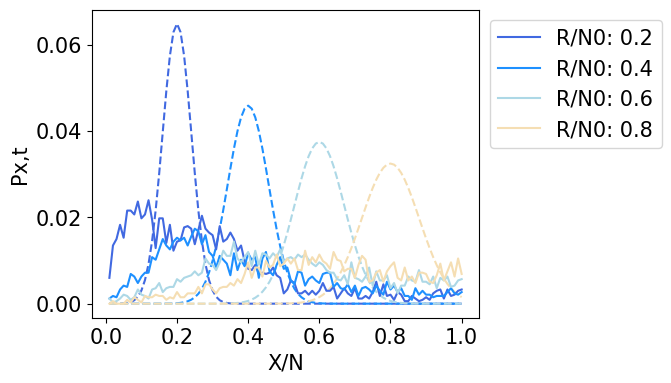

In [40]:
import math
# https://www.desmos.com/calculator/gbypgswp6c
# v = 0.0021 - a randomly chosen element gets replaced by a new one with probability ν
# tau = 0.1024 - element moves to a randomly selected rank with probability τ
tau = 0.1024
v = 0.0021
N = billboard_hot_100["artist_song"].nunique()
N0 = 100
p0 = N0 / N
initial_ranks = [20, 40, 60, 80]
pxts = []
dr = 1/N

plt.figure(figsize=(5, 4))

colors = ["royalblue", "dodgerblue", "lightblue", "wheat", "sandybrown", "chocolate"]
#model
t=4
for i, initial_rank in enumerate(initial_ranks):
    #https://github.com/iniguezg/Farranks/tree/9b661fb269b52a381bc47662d0f573bbdafe011c
    r = (initial_rank) * dr
    ptau, pnu = tau, v

    dr = 1 / float( N ) #rank increment
    p0 = N0 / float( N ) #ranking fraction

    x_vals = np.linspace( dr, p0, num=N0 ) #values of displaced rank

    levi_sea = dr * ( 1 - np.exp( -ptau * t ) )
    peak_sdev = np.sqrt( 2 * ptau * dr * r * (1 - r) * t )
    disp_theo = np.exp( -pnu * t ) * ( levi_sea + np.exp( -ptau * t ) * st.norm.pdf( x_vals, loc=r, scale=peak_sdev ) * dr )

    pxts.append(disp_theo)

xplot = np.arange( 1, 101 ) / 100
for i, initial_rank in enumerate(initial_ranks):
    plt.plot(xplot, pxts[i], c=colors[i], linestyle="dashed")

#data
pxts = []
for i, initial_rank in tqdm(enumerate(initial_ranks)):
    pxts.append([])
    for j, pos in enumerate(range(1, 101)):
        pxts[i].append([])
        for t in all_t[5:]:
            try:
                Pxt = probability_4(data, initial_rank, pos, t)
                pxts[i][j].append(Pxt)
            except Exception as e:
                continue
        pxts[i][j] = np.mean(pxts[i][j])

for i, initial_rank in enumerate(initial_ranks):
    plt.plot(xplot, pxts[i], label=f"R/N0: {initial_rank/100}", c=colors[i])

plt.ylabel("Px,t")
plt.xlabel("X/N")
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("figures/pxt_4.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Rate of element replacement

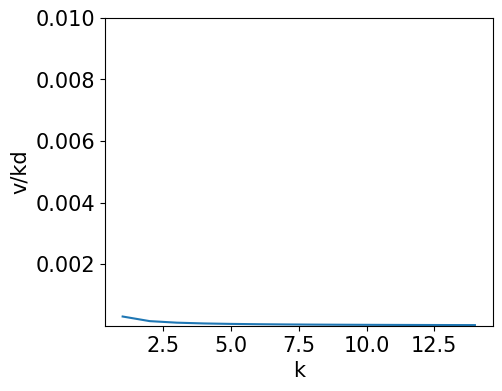

In [38]:
plt.figure(figsize=(5, 4))

rates = []
for k in range(1, 15):
    rate = v / (k * 7)
    rates.append(rate)
plt.plot(range(1, 15), rates)
plt.ylabel("v/kd")
plt.xlabel("k")
plt.ylim([0.000001, 0.01])
plt.show()

## Average probability that an element changes rank by Levy walk, diffusion or is replaced

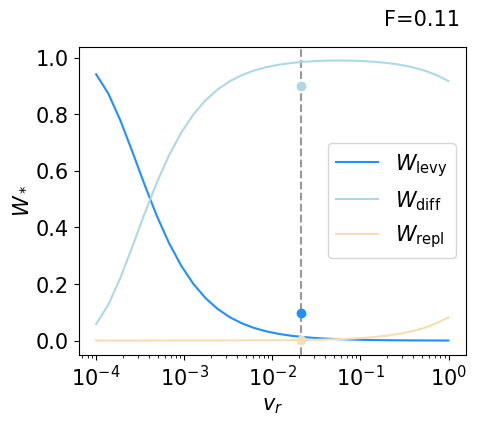

In [44]:
plt.figure(figsize=(5, 4))

colors = ["dodgerblue", "lightblue", "wheat", "sandybrown"]
open_deriv = mean_turnover

pnu_resc = ( pnu - p0 * open_deriv ) / open_deriv
ptau_resc = ptau / ( p0 * (1 - p0) * open_deriv )

W_repl = 1 - np.exp( -pnu )
W_diff = np.exp( -pnu ) * np.exp( -ptau )
W_levy = np.exp( -pnu ) * ( 1 - np.exp( -ptau ) )

pnu_resc_vals = np.logspace( -4, np.log10( 1 - p0 ), 30 ) #pick rescaled pnu as variable
ptau_resc_vals = 1 / pnu_resc_vals #and slide over universal curve

#model parameters
pnu_vals = ( pnu_resc_vals + p0 ) * open_deriv
ptau_vals = ptau_resc_vals * p0 * (1 - p0) * open_deriv

#regime probabilities (with t=1)
W_repl_vals = 1 - np.exp( -pnu_vals )
W_diff_vals = np.exp( -pnu_vals ) * np.exp( -ptau_vals )
W_levy_vals = np.exp( -pnu_vals ) * ( 1 - np.exp( -ptau_vals ) )

#regime probabilities (in data)
handle_data, = plt.semilogx( pnu_resc, W_levy, 'o', label=None, c=colors[0], zorder=2 )
plt.semilogx( pnu_resc, W_diff, 'o', label=None, c=colors[1], zorder=2 )
plt.semilogx( pnu_resc, W_repl, 'o', label=None, c=colors[2], zorder=2 )

#(variable) regime probabilities
handle_model, = plt.semilogx( pnu_resc_vals, W_levy_vals, label='$W_{\mathrm{levy}}$', c=colors[0], zorder=1 )
plt.semilogx( pnu_resc_vals, W_diff_vals, label='$W_{\mathrm{diff}}$', c=colors[1], zorder=1 )
plt.semilogx( pnu_resc_vals, W_repl_vals, label='$W_{\mathrm{repl}}$', c=colors[2], zorder=1 )
plt.text( 0.5, 1.1, f"F={round(mean_flux, 2)}", va='bottom', ha='center')

plt.xlabel(r'$v_r$')
plt.ylabel(r'$W_*$')

#line at rescaled pnu
handle_param = plt.axvline( pnu_resc, ls='--', c='0.6', label=None, zorder=0 )

plt.legend()
plt.savefig("figures/levy_diff_repl.pdf", format="pdf", bbox_inches="tight")
plt.show()


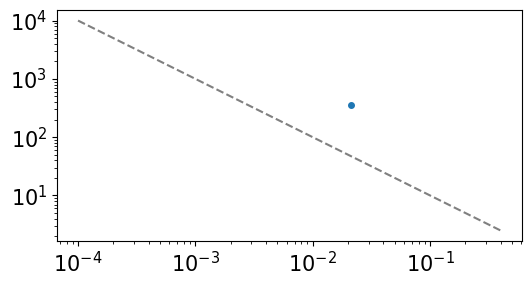

In [43]:
plt.figure(figsize=(6, 3))

plt.loglog(pnu_resc, ptau_resc, 'o', ms=4, zorder=1 )

pnu_resc_vals = np.logspace( -4, np.log10( 4e-1 ), 30 ) #pick rescaled pnu as variable
ptau_resc_vals = 1 / pnu_resc_vals #and slide over universal curve
plt.loglog( pnu_resc_vals, ptau_resc_vals, '--', c='0.5')
plt.show()

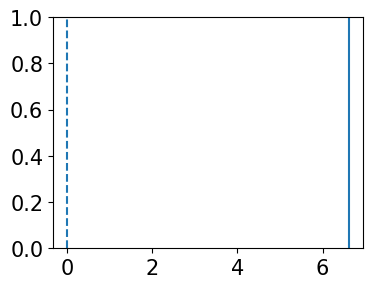

In [46]:
plt.figure(figsize=(4, 3))

curve = pnu_resc * ptau_resc - 1

plt.axvline(x=curve)
plt.axvline(x=0, ls='--')
plt.show()

## Probability of staying or increasing position for top 10 over time

In [47]:
def calculate_position_change(position, last_week_position):
    if np.isnan(last_week_position):
        return np.nan
    if position <= last_week_position:
        return 1
    else:
        return 0

billboard_hot_100["position_didnt_fall"] = billboard_hot_100.apply(
    lambda x: calculate_position_change(x["position"], x["last_week_position"]), axis=1)

In [48]:
def position_range(position):
    if position <= 10:
        return "1-10"
    elif position <= 50:
        return "10-50"
    return "50-100"

billboard_hot_100["position_range"] = billboard_hot_100.apply(
    lambda x: position_range(x["position"]), axis=1)

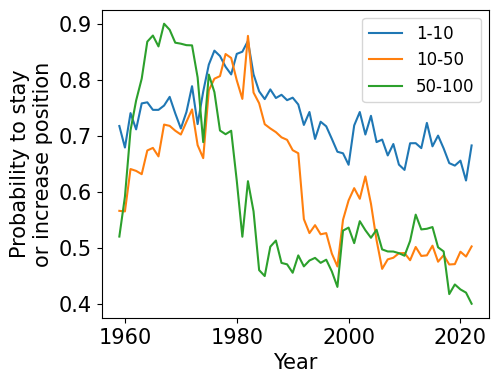

In [64]:
plt.figure(figsize=(5, 4))

billboard_hot_10 = billboard_hot_100[billboard_hot_100["position"] <= 10]
billboard_hot_10 = billboard_hot_10[~billboard_hot_10["position_didnt_fall"].isna()]
billboard_hot_10.sort_values(by="year")
billboard_hot_10.groupby("year")["position_didnt_fall"].mean().plot(label="1-10")

billboard_hot_10_50 = billboard_hot_100[(billboard_hot_100["position"] > 10) &\
                                     (billboard_hot_100["position"] < 50)]
billboard_hot_10_50 = billboard_hot_10_50[~billboard_hot_10_50["position_didnt_fall"].isna()]
billboard_hot_10_50.sort_values(by="year")
billboard_hot_10_50.groupby("year")["position_didnt_fall"].mean().plot(label="10-50")

billboard_hot_50_100 = billboard_hot_100[billboard_hot_100["position"] >= 50]
billboard_hot_50_100 = billboard_hot_50_100[~billboard_hot_50_100["position_didnt_fall"].isna()]
billboard_hot_50_100.sort_values(by="year")
billboard_hot_50_100.groupby("year")["position_didnt_fall"].mean().plot(label="50-100")

plt.ylabel("Probability to stay\nor increase position")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1, 1), loc="upper right", fontsize=12)
plt.savefig("figures/probability_to_not_decrease_position.pdf", format="pdf", bbox_inches="tight")

plt.show()

## How many artists get to be in top x-y in each year

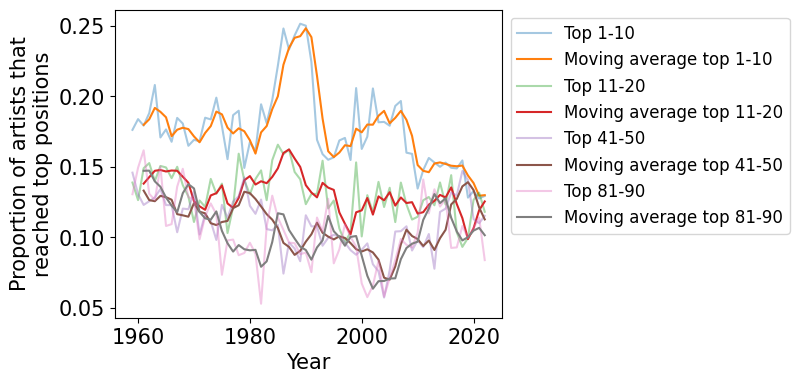

In [65]:
plt.figure(figsize=(5, 4))

previous = None
for i in range(10, 101, 10):
    if i in (10, 20, 50, 90):
        billboard_hot_100[f"top_{i}"] = (billboard_hot_100["top_position"] > i - 9) & (billboard_hot_100["top_position"] <= i)
        billboard_hot_100[["artist", f"top_{i}", "year"]].drop_duplicates().groupby("year")[f"top_{i}"].mean().plot(label=f"Top {i-9}-{i}", alpha=0.4)
        billboard_hot_100[["artist", f"top_{i}", "year"]].drop_duplicates().groupby("year")[f"top_{i}"].mean().rolling(window=3).mean().plot(label=f"Moving average top {i-9}-{i}")

plt.xlabel("Year")
plt.ylabel("Proportion of artists that\nreached top positions")
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig("figures/proportion_of_top_x_yearly.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Percentage of new artists weekly

In [7]:
def generate_weeks(first_week, last_week):
    current_week = first_week
    while current_week <= last_week:
        yield current_week
        current_week += timedelta(weeks=1)

100%|██████████| 63/63 [00:02<00:00, 29.90it/s]


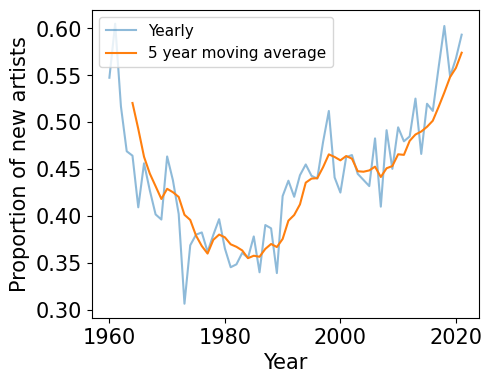

In [8]:
plt.figure(figsize=(5, 4))

percentages = []
first_week = billboard_hot_100["first_day_of_the_week"].min() + timedelta(weeks=1)
last_week = billboard_hot_100["first_day_of_the_week"].max()
years = range(1959, 2022)

for year in tqdm(years):
    artists_from_year = billboard_hot_100[billboard_hot_100["year"] == year][["artist"]].drop_duplicates()
    artists_from_previous_years = billboard_hot_100[billboard_hot_100["year"] < year]["artist"].drop_duplicates()
    new_artists = artists_from_year[~artists_from_year["artist"].isin(artists_from_previous_years)]
    percentage_of_new_artists = len(new_artists)/len(artists_from_year)
    percentages.append(percentage_of_new_artists)

plt.plot(years[1:], percentages[1:], alpha=0.5)
plt.plot(years[5:], moving_average(percentages[1:], 5))

plt.xlabel("Year")
plt.ylabel("Proportion of new artists")
plt.legend(["Yearly", "5 year moving average"], loc="upper left", fontsize=11)
plt.savefig("figures/proportion_of_new_artists.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Percentage of features

100%|██████████| 63/63 [00:00<00:00, 160.60it/s]


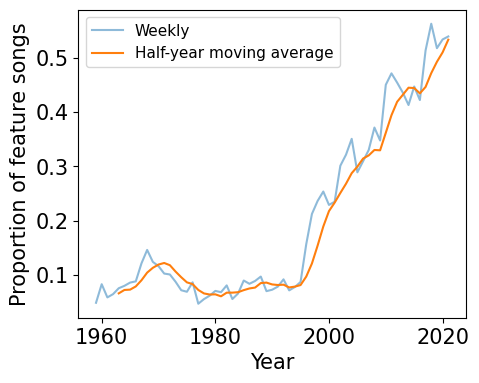

In [9]:
plt.figure(figsize=(5, 4))

percentages = []
weeks = range(1959, 2023)

for year in tqdm(years):
    artists_from_year = billboard_hot_100[billboard_hot_100["year"] == year][["artist"]].drop_duplicates()
    artists_features = artists_from_year[(artists_from_year["artist"].str.lower().str.contains("featuring")) |\
        (artists_from_year["artist"].str.lower().str.contains("&"))]
    percentage_of_new_features = len(artists_features)/len(artists_from_year)
    percentages.append(percentage_of_new_features)

plt.plot(years, percentages, alpha=0.5)
plt.plot(years[4:], moving_average(percentages, 5))

plt.xlabel("Year")
plt.ylabel("Proportion of feature songs")
plt.legend(["Weekly", "Half-year moving average"], loc="upper left", fontsize=11)
plt.savefig("figures/proportion_of_features.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Proportion of new artists without features

100%|██████████| 63/63 [00:27<00:00,  2.29it/s]


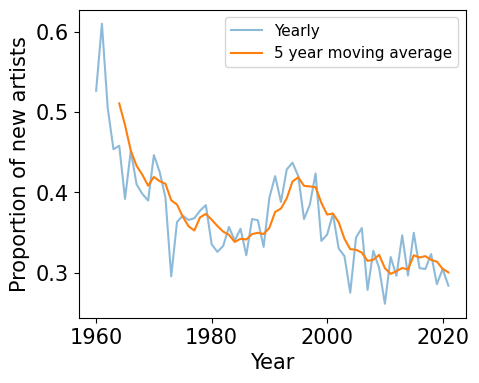

In [10]:
plt.figure(figsize=(5, 4))

percentages = []
first_week = billboard_hot_100["first_day_of_the_week"].min() + timedelta(weeks=1)
last_week = billboard_hot_100["first_day_of_the_week"].max()
years = range(1959, 2022)

for year in tqdm(years):
    artists_from_year = billboard_hot_100[(billboard_hot_100["year"] == year) &\
        ~((billboard_hot_100["artist"].str.lower().str.contains("featuring")) |\
        (billboard_hot_100["artist"].str.lower().str.contains("&")))][["artist"]].drop_duplicates()
    artists_from_previous_years = billboard_hot_100[billboard_hot_100["year"] < year]["artist"].drop_duplicates()
    new_artists = artists_from_year[~artists_from_year["artist"].isin(artists_from_previous_years)]
    percentage_of_new_artists = len(new_artists)/len(artists_from_year)
    percentages.append(percentage_of_new_artists)

plt.plot(years[1:], percentages[1:], alpha=0.5)
plt.plot(years[5:], moving_average(percentages[1:], 5))

plt.xlabel("Year")
plt.ylabel("Proportion of new artists")
plt.legend(["Yearly", "5 year moving average"], loc="upper right", fontsize=11)
plt.savefig("figures/proportion_of_new_artists_without_features.pdf", format="pdf", bbox_inches="tight")
plt.show()

## How many new artists reach top 10 in each year

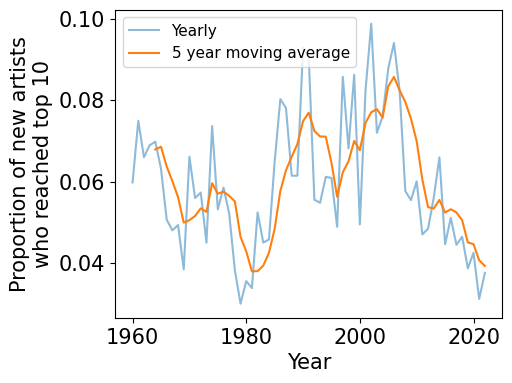

In [11]:
plt.figure(figsize=(5, 4))

percentages = []
for year in range(1959, 2023):
    artists_from_year = billboard_hot_100[billboard_hot_100["year"] == year][["artist", "top_position"]].drop_duplicates()
    artists_from_previous_years = billboard_hot_100[billboard_hot_100["year"] < year]["artist"].drop_duplicates()
    new_artists = artists_from_year[~artists_from_year["artist"].isin(artists_from_previous_years)]
    new_artists_top_10 = new_artists[new_artists["top_position"] <= 10]
    percentage_of_new_artists = len(new_artists_top_10)/len(artists_from_year)
    percentages.append(percentage_of_new_artists)

plt.plot(range(1959, 2023)[1:], percentages[1:], alpha=0.5)
plt.plot(range(1959, 2023)[5:], moving_average(percentages[1:], 5))

plt.xlabel("Year")
plt.ylabel("Proportion of new artists\nwho reached top 10")
plt.legend(["Yearly", "5 year moving average"], loc="upper left", fontsize=11)
plt.savefig("figures/proportion_of_new_artists_top_10_yearly.pdf", format="pdf", bbox_inches="tight")
plt.show()

## How many new artists reach top 10 without features

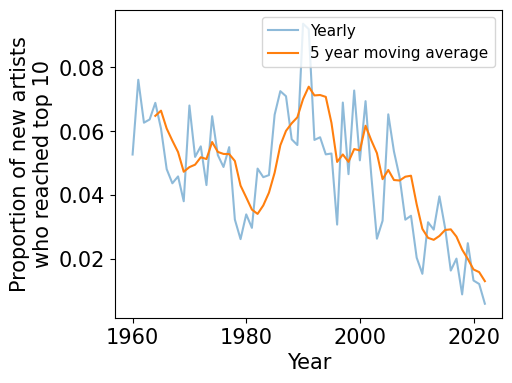

In [12]:
plt.figure(figsize=(5, 4))

percentages = []
for year in range(1959, 2023):
    artists_from_year = billboard_hot_100[(billboard_hot_100["year"] == year) &\
        ~((billboard_hot_100["artist"].str.lower().str.contains("featuring")) |\
        (billboard_hot_100["artist"].str.lower().str.contains("&")))][["artist", "top_position"]].drop_duplicates()
    artists_from_previous_years = billboard_hot_100[billboard_hot_100["year"] < year]["artist"].drop_duplicates()
    new_artists = artists_from_year[~artists_from_year["artist"].isin(artists_from_previous_years)]
    new_artists_top_10 = new_artists[new_artists["top_position"] <= 10]
    percentage_of_new_artists = len(new_artists_top_10)/len(artists_from_year)
    percentages.append(percentage_of_new_artists)

plt.plot(range(1959, 2023)[1:], percentages[1:], alpha=0.5)
plt.plot(range(1959, 2023)[5:], moving_average(percentages[1:], 5))

plt.xlabel("Year")
plt.ylabel("Proportion of new artists\nwho reached top 10")
plt.legend(["Yearly", "5 year moving average"], loc="upper right", fontsize=11)
plt.savefig("figures/proportion_of_new_artists_top_10_yearly_without_feature.pdf", format="pdf", bbox_inches="tight")
plt.show()

## How many artists reached top 10, who had reached top 10 before

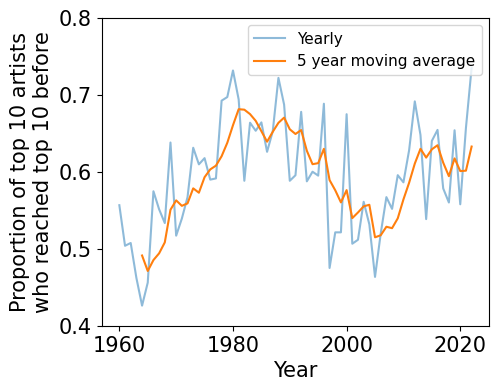

In [74]:
plt.figure(figsize=(5, 4))

percentages = []
for year in range(1959, 2023):
    artists_from_year = billboard_hot_100[billboard_hot_100["year"] == year][["artist", "top_position"]].drop_duplicates()
    artists_from_previous_years = billboard_hot_100[billboard_hot_100["year"] < year][["artist", "top_position"]].drop_duplicates()
    artists_from_previous_years_top_10 = artists_from_previous_years[artists_from_previous_years["top_position"] <= 10]
    artists_from_this_year_top_10 = artists_from_year[artists_from_year["top_position"] <= 10]
    artists_top_10_never_in_top_10_before = artists_from_this_year_top_10[artists_from_this_year_top_10["artist"].isin(artists_from_previous_years_top_10["artist"])]
    percentage_of_artists = len(artists_top_10_never_in_top_10_before)/len(artists_from_this_year_top_10)
    percentages.append(percentage_of_artists)

plt.plot(range(1959, 2023)[1:], percentages[1:], alpha=0.5)
plt.plot(range(1959, 2023)[5:], moving_average(percentages[1:], 5))
plt.ylim([0.4, 0.8])

plt.xlabel("Year")
plt.ylabel("Proportion of top 10 artists\nwho reached top 10 before")
plt.legend(["Yearly", "5 year moving average"], loc="upper right", fontsize=11)
plt.savefig("figures/proportion_of_artists_in_top_10_again_yearly.pdf", format="pdf", bbox_inches="tight")
plt.show()

## What % of artists appear only once in the charts in the lifetime (no collabs)

In [75]:
number_of_songs = billboard_hot_100[["artist", "song_name"]].drop_duplicates().groupby("artist")["song_name"].count().reset_index(name="song_count")
billboard_hot_100["number_of_songs"] = billboard_hot_100["artist"].progress_map(lambda artist: number_of_songs[number_of_songs["artist"] == artist]["song_count"].iloc[0])

100%|██████████| 333887/333887 [14:37<00:00, 380.30it/s]


100%|██████████| 63/63 [00:00<00:00, 86.80it/s]


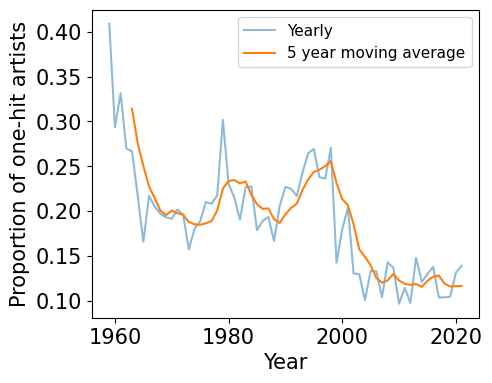

In [76]:
plt.figure(figsize=(5, 4))

percentages = []
first_week = billboard_hot_100["first_day_of_the_week"].min() + timedelta(weeks=1)
last_week = billboard_hot_100["first_day_of_the_week"].max()
years = range(1959, 2022)

for year in tqdm(years):
    artists_from_year = billboard_hot_100[billboard_hot_100["year"] == year][['artist', "number_of_songs"]].drop_duplicates()
    if (len(artists_from_year) == 0):
        percentages.append(0)
        continue
    artists_with_one_song = artists_from_year[(artists_from_year["number_of_songs"] == 1) &\
        ~((artists_from_year["artist"].str.lower().str.contains("featuring")) |\
        (artists_from_year["artist"].str.lower().str.contains("&")))]
    percentages.append(artists_with_one_song.shape[0] / artists_from_year.shape[0])

plt.plot(years, percentages, alpha=0.5)
plt.plot(years[4:], moving_average(percentages, 5))

plt.xlabel("Year")
plt.ylabel("Proportion of one-hit artists")
plt.legend(["Yearly", "5 year moving average"], loc="upper right", fontsize=11)
plt.savefig("figures/proportion_of_one_hit_artists.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Distribution of number of songs

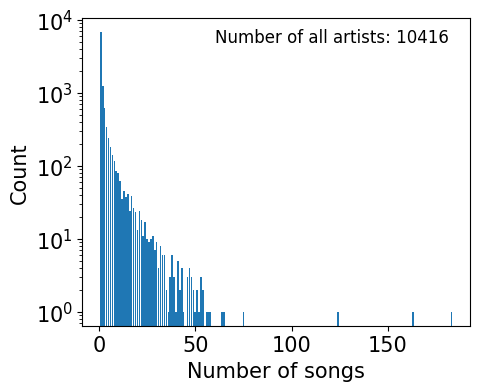

In [96]:
plt.figure(figsize=(5, 4))

numbers_of_songs = billboard_hot_100[["artist", "number_of_songs"]].drop_duplicates()
count_numbers_of_songs = numbers_of_songs["number_of_songs"].value_counts().sort_index()

plt.bar(count_numbers_of_songs.index, count_numbers_of_songs.values)
nartists = billboard_hot_100["artist"].nunique()
plt.text(60, 5000, f"Number of all artists: {nartists}", fontsize=12)

plt.xlabel("Number of songs")
plt.ylabel("Count")
plt.yscale("log")
plt.savefig("figures/number_of_songs_per_artist.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Distribution of number of songs in top 10

In [78]:
billboard_hot_100["top_10"] = billboard_hot_100["top_position"] <= 10
number_of_songs_10 = billboard_hot_100[["artist", "song_name", "top_10"]].drop_duplicates().groupby("artist")["top_10"].sum().reset_index(name="top_10_count")

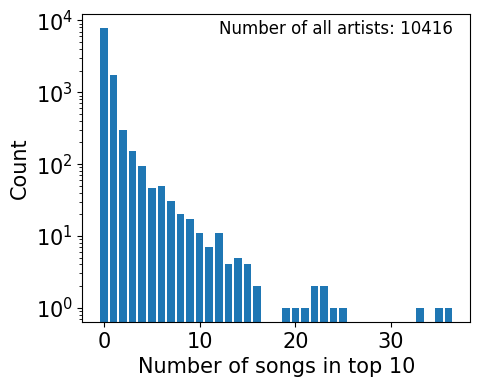

In [97]:
plt.figure(figsize=(5, 4))

count_numbers_of_songs = number_of_songs_10["top_10_count"].value_counts().sort_index()

plt.bar(count_numbers_of_songs.index, count_numbers_of_songs.values)
nartists = billboard_hot_100["artist"].nunique()
plt.text(12, 6500, f"Number of all artists: {nartists}", fontsize=12)

plt.xlabel("Number of songs in top 10")
plt.ylabel("Count")
plt.yscale("log")
plt.savefig("figures/number_of_songs_in_top_10_per_artist.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Average number of songs up until t

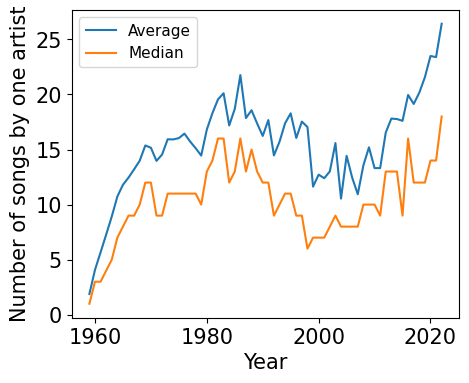

In [80]:
plt.figure(figsize=(5, 4))

songs_numbers_count = billboard_hot_100[["year", "artist", "song_name"]].groupby(["year", "artist"])["song_name"].nunique().reset_index(name="number_of_songs")
averages = []
medians = []

for year in range(1959, 2023):
    songs_until_year = songs_numbers_count[songs_numbers_count["year"] <= year].copy()
    songs_until_year["total_number_of_songs"] = songs_until_year.groupby(["artist"])["number_of_songs"].transform("sum")
    songs_from_this_year = songs_until_year[songs_until_year["year"] == year]["artist"]
    numbers_of_songs = songs_until_year[songs_until_year["artist"].isin(songs_from_this_year)]
    averages.append(numbers_of_songs["total_number_of_songs"].mean())
    medians.append(numbers_of_songs["total_number_of_songs"].median())
    
plt.plot(range(1959, 2023), averages)
plt.plot(range(1959, 2023), medians)
plt.xlabel("Year")
plt.ylabel("Number of songs by one artist")
plt.legend(["Average", "Median"], loc="upper left", fontsize=11)
plt.savefig("figures/number_of_songs_by_one_artist.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Propotion of artists who have had more than x songs in the charts

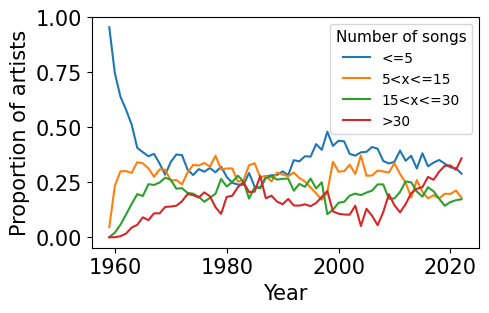

In [101]:
plt.figure(figsize=(5, 3))

songs_numbers_count = billboard_hot_100[["year", "artist", "song_name"]].groupby(["year", "artist"])["song_name"].nunique().reset_index(name="number_of_songs")
averages_5_less = []
averages_3 = []
averages_5 = []
averages_10 = []

for year in range(1959, 2023):
    songs_until_year = songs_numbers_count[songs_numbers_count["year"] <= year].copy()
    songs_until_year["total_number_of_songs"] = songs_until_year.groupby(["artist"])["number_of_songs"].transform("sum")
    songs_from_this_year = songs_until_year[songs_until_year["year"] == year]["artist"]
    numbers_of_songs = songs_until_year[songs_until_year["artist"].isin(songs_from_this_year)].copy()
    numbers_of_songs["less_than_5"] = (numbers_of_songs["total_number_of_songs"] <= 5)
    numbers_of_songs["more_than_3_songs"] = (numbers_of_songs["total_number_of_songs"] > 5) & (numbers_of_songs["total_number_of_songs"] <= 15)
    numbers_of_songs["more_than_5_songs"] = (numbers_of_songs["total_number_of_songs"] > 15) & (numbers_of_songs["total_number_of_songs"] <= 30)
    numbers_of_songs["more_than_10_songs"] = numbers_of_songs["total_number_of_songs"] > 30
    averages_3.append(numbers_of_songs["more_than_3_songs"].mean())
    averages_5.append(numbers_of_songs["more_than_5_songs"].mean())
    averages_10.append(numbers_of_songs["more_than_10_songs"].mean())
    averages_5_less.append(numbers_of_songs["less_than_5"].mean())
    
plt.plot(range(1959, 2023), averages_5_less)
plt.plot(range(1959, 2023), averages_3)
plt.plot(range(1959, 2023), averages_5)
plt.plot(range(1959, 2023), averages_10)
plt.xlabel("Year")
plt.ylabel("Proportion of artists")
legend = plt.legend(["<=5", "5<x<=15", "15<x<=30", ">30"], title="Number of songs", fontsize=10)
legend.get_title().set_fontsize('11')
plt.savefig("figures/proportion_of_artists_by_number_of_songs.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Propotion of artists who have had more than x songs in the charts (no features, collabs)

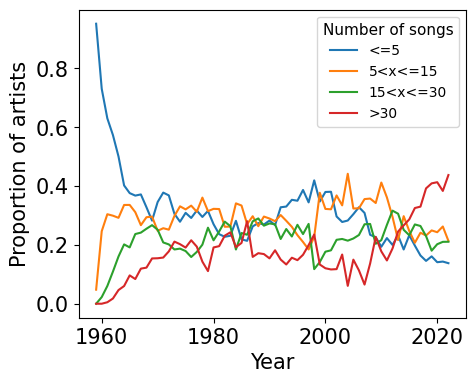

In [103]:
plt.figure(figsize=(5, 4))

df = billboard_hot_100[~((billboard_hot_100["artist"].str.lower().str.contains("featuring")) |\
        (billboard_hot_100["artist"].str.lower().str.contains("&")))]
songs_numbers_count = df[["year", "artist", "song_name"]].groupby(["year", "artist"])["song_name"].nunique().reset_index(name="number_of_songs")
averages_5_less = []
averages_3 = []
averages_5 = []
averages_10 = []

for year in range(1959, 2023):
    songs_until_year = songs_numbers_count[songs_numbers_count["year"] <= year].copy()
    songs_until_year["total_number_of_songs"] = songs_until_year.groupby(["artist"])["number_of_songs"].transform("sum")
    songs_from_this_year = songs_until_year[songs_until_year["year"] == year]["artist"]
    numbers_of_songs = songs_until_year[songs_until_year["artist"].isin(songs_from_this_year)].copy()
    numbers_of_songs["less_than_5"] = (numbers_of_songs["total_number_of_songs"] <= 5)
    numbers_of_songs["more_than_3_songs"] = (numbers_of_songs["total_number_of_songs"] > 5) & (numbers_of_songs["total_number_of_songs"] <= 15)
    numbers_of_songs["more_than_5_songs"] = (numbers_of_songs["total_number_of_songs"] > 15) & (numbers_of_songs["total_number_of_songs"] <= 30)
    numbers_of_songs["more_than_10_songs"] = numbers_of_songs["total_number_of_songs"] > 30
    averages_3.append(numbers_of_songs["more_than_3_songs"].mean())
    averages_5.append(numbers_of_songs["more_than_5_songs"].mean())
    averages_10.append(numbers_of_songs["more_than_10_songs"].mean())
    averages_5_less.append(numbers_of_songs["less_than_5"].mean())
    
plt.plot(range(1959, 2023), averages_5_less)
plt.plot(range(1959, 2023), averages_3)
plt.plot(range(1959, 2023), averages_5)
plt.plot(range(1959, 2023), averages_10)
plt.xlabel("Year")
plt.ylabel("Proportion of artists")
legend = plt.legend(["<=5", "5<x<=15", "15<x<=30", ">30"], title="Number of songs", fontsize=10, bbox_to_anchor=(1, 1))
legend.get_title().set_fontsize('11')
plt.savefig("figures/proportion_of_artists_by_number_of_songs_without_collaborations.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Number of songs vs weeks on chart

In [119]:
billboard_hot_100["max_weeks_on_chart"] = billboard_hot_100.groupby(["artist", "song_name"])["weeks_on_chart"].transform("max")

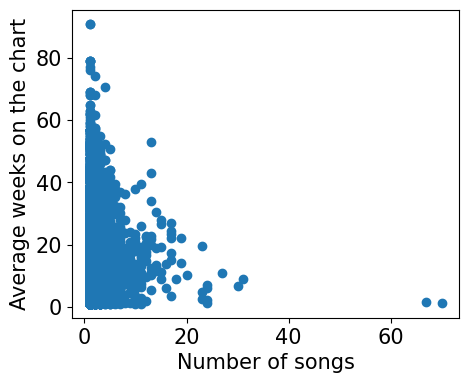

In [125]:
plt.figure(figsize=(5, 4))

songs_numbers_count = billboard_hot_100[["year", "artist", "song_name"]].sort_values(["artist", "year"]).groupby(["year", "artist"])["song_name"].nunique().reset_index(name="number_of_songs")
average_weeks_on_chart = billboard_hot_100[["year", "artist", "max_weeks_on_chart"]].sort_values(["artist", "year"]).groupby(["year", "artist"])["max_weeks_on_chart"].mean().reset_index(name="average_weeks_on_chart")

plt.scatter(songs_numbers_count["number_of_songs"], average_weeks_on_chart["average_weeks_on_chart"])
plt.xlabel("Number of songs")
plt.ylabel("Average weeks on the chart")
plt.savefig("figures/number_of_songs_vs_average_weeks_on_the_chart.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Number of distinct songs each year

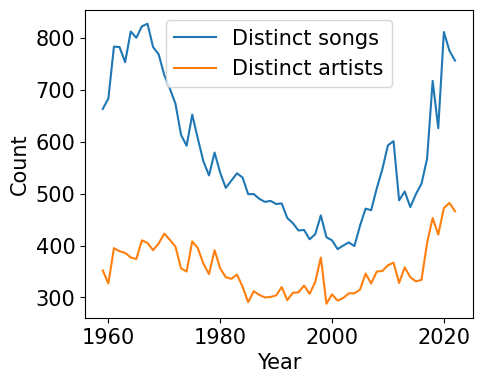

In [104]:
plt.figure(figsize=(5, 4))

numbers_of_songs = billboard_hot_100[["artist_song", "year"]].drop_duplicates()
numbers_of_songs.groupby("year")["artist_song"].count().plot()
billboard_hot_100[["artist", "year"]].drop_duplicates().groupby("year")["artist"].count().plot()

plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(["Distinct songs", "Distinct artists"])
plt.savefig("figures/number_of_distinct_songs_and_artists.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Percent of songs lasting x weeks

In [105]:
def weeks_on_chart_range(weeks_on_chart):
    if weeks_on_chart <= 5:
        return "<=5"
    if weeks_on_chart <= 10:
        return "5 < x <=10"
    if weeks_on_chart <= 20:
        return "10 < x <=20"
    return ">20"

billboard_hot_100["weeks_on_chart_range"] = billboard_hot_100["weeks_on_chart"].map(weeks_on_chart_range)

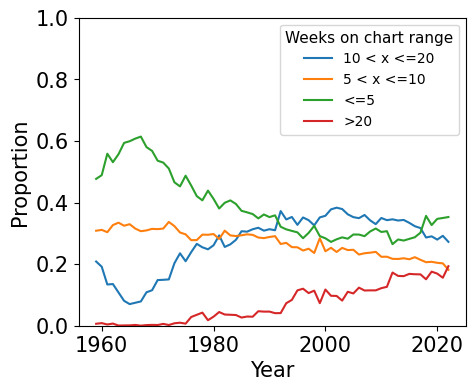

In [108]:
billboard_hot_100.groupby(["year"])["weeks_on_chart_range"].value_counts(
    normalize=True).unstack(fill_value=0).stack().sort_index().unstack().plot(figsize=(5, 4))

plt.xlabel("Year")
plt.ylabel("Proportion")
plt.ylim([0, 1])
legend = plt.legend(title="Weeks on chart range", loc="upper right", fontsize=10)
legend.get_title().set_fontsize('11')
plt.savefig("figures/proportion_of_songs_by_weeks_on_chart_range.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Repeat hitmakers

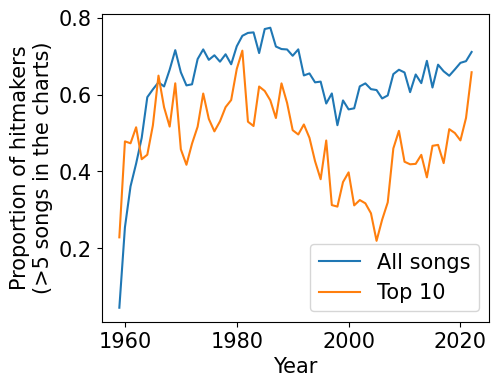

In [109]:
plt.figure(figsize=(5, 4))

songs_numbers_count = billboard_hot_100[["year", "artist", "song_name"]].groupby(["year", "artist"])["song_name"].nunique().reset_index(name="number_of_songs")
averages = []
averages_10 = []
medians = []

for year in range(1959, 2023):
    songs_until_year = songs_numbers_count[songs_numbers_count["year"] <= year].copy()
    songs_until_year["total_number_of_songs"] = songs_until_year.groupby(["artist"])["number_of_songs"].transform("sum")
    songs_from_this_year = songs_until_year[songs_until_year["year"] == year]["artist"]
    numbers_of_songs = songs_until_year[songs_until_year["artist"].isin(songs_from_this_year)].drop_duplicates().copy()
    numbers_of_songs["hitmaker"] = numbers_of_songs["total_number_of_songs"] > 5
    averages.append(numbers_of_songs["hitmaker"].mean())

    hitmakers = numbers_of_songs[numbers_of_songs["hitmaker"] == True]["artist"]
    songs_data_from_this_year = billboard_hot_100[billboard_hot_100["year"] == year][["artist", "year", "top_position"]].drop_duplicates().copy()
    songs_data_from_this_year = songs_data_from_this_year[songs_data_from_this_year["top_position"] <= 10]
    songs_data_from_this_year["hitmaker"] = songs_data_from_this_year["artist"].isin(hitmakers)
    averages_10.append(songs_data_from_this_year["hitmaker"].mean())
    
plt.plot(range(1959, 2023), averages)
plt.plot(range(1959, 2023), averages_10)
plt.xlabel("Year")
plt.ylabel("Proportion of hitmakers\n(>5 songs in the charts)")
plt.legend(["All songs", "Top 10"])
plt.savefig("figures/proportion_of_hitmakers.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Repeat hitmakers (top 10)

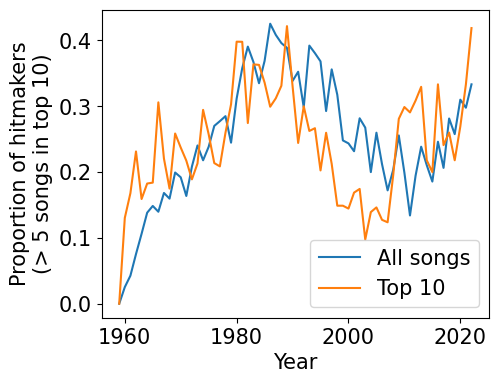

In [110]:
plt.figure(figsize=(5, 4))

number_of_songs_10 = billboard_hot_100[["year", "artist", "song_name", "top_10"]].drop_duplicates().groupby(["year", "artist"])["top_10"].sum().reset_index(name="top_10_count")
averages = []
averages_10 = []
medians = []

for year in range(1959, 2023):
    songs_until_year = number_of_songs_10[number_of_songs_10["year"] <= year].copy()
    songs_until_year["total_number_of_songs"] = songs_until_year.groupby(["artist"])["top_10_count"].transform("sum")
    songs_from_this_year = songs_until_year[songs_until_year["year"] == year]["artist"]
    numbers_of_songs = songs_until_year[songs_until_year["artist"].isin(songs_from_this_year)].drop_duplicates().copy()
    numbers_of_songs["hitmaker"] = numbers_of_songs["total_number_of_songs"] > 5
    averages.append(numbers_of_songs["hitmaker"].mean())

    hitmakers = numbers_of_songs[numbers_of_songs["hitmaker"] == True]["artist"]
    songs_data_from_this_year = billboard_hot_100[billboard_hot_100["year"] == year][["artist", "year", "top_position"]].drop_duplicates().copy()
    songs_data_from_this_year = songs_data_from_this_year[songs_data_from_this_year["top_position"] <= 10]
    songs_data_from_this_year["hitmaker"] = songs_data_from_this_year["artist"].isin(hitmakers)
    averages_10.append(songs_data_from_this_year["hitmaker"].mean())
    
plt.plot(range(1959, 2023), averages)
plt.plot(range(1959, 2023), averages_10)
plt.xlabel("Year")
plt.ylabel("Proportion of hitmakers\n(> 5 songs in top 10)")
plt.legend(["All songs", "Top 10"])
plt.savefig("figures/proportion_of_hitmakers_top_10.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Distribution of number of artists per top positions yearly

In [111]:
def get_top_positions_range(position):
    if position <= 10:
        return "1-10"
    elif position <= 20:
        return "11-20"
    elif position <= 30:
        return "21-30"
    elif position <= 40:
        return "31-40"
    elif position <= 50:
        return "41-50"
    elif position <= 60:
        return "51-60"
    elif position <= 70:
        return "61-70"
    elif position <= 80:
        return "71-80"
    elif position <= 90:
        return "81-90"
    else:
        return "91-100"

billboard_hot_100["top_positions_range"] = billboard_hot_100["top_position"].map(
    lambda position: get_top_positions_range(position))

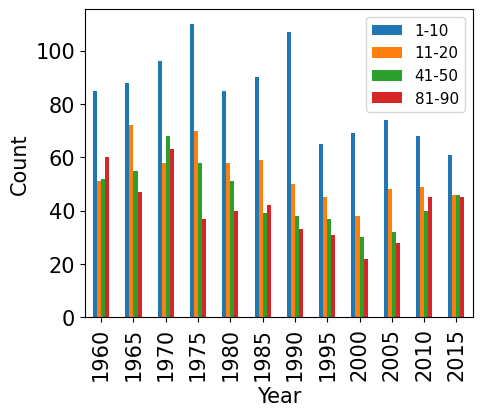

In [117]:
billboard_hot_100_no_dups = billboard_hot_100[["year", "artist", "top_positions_range"]].drop_duplicates()
billboard_hot_100_no_dups = billboard_hot_100_no_dups[billboard_hot_100_no_dups["year"].isin(range(1960, 2020, 5))]
billboard_hot_100_no_dups[billboard_hot_100_no_dups["top_positions_range"].isin(["1-10", "11-20", "41-50", "81-90"])].groupby("year")[
    "top_positions_range"].value_counts().unstack().plot(kind="bar", figsize=(5, 4))

plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(fontsize=11, loc="upper right")
plt.savefig("figures/top_positions_range_distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()